In [1]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import os
from pydub import AudioSegment

import matplotlib.pyplot as plt
str(torchaudio.get_audio_backend())

'soundfile'

In [2]:
if torch.cuda.is_available():
    # Set the default device to the first available GPU (index 0)
    torch.cuda.set_device(0)
    device = torch.device('cuda')
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 4070 Ti


In [3]:
# # convert all mp3 to wav
# genre_folder = r""
# i = 10
#
# for song in os.listdir(genre_folder):
#     song_path = os.path.join(genre_folder, song)
#     audio = AudioSegment.from_mp3(song_path)
#     wav_file_path = os.path.join(genre_folder, str(i) + ".wav")
#     audio.export(wav_file_path, format="wav")
#     i += 1

In [4]:
# block_size = 1 # context length: how many seconds do we take to predict the next one?
# downsample_size = 100
# sample_rate = 44100
# input_size = sample_rate // downsample_size
# target_size = sample_rate // downsample_size
# X = []
# Y = []
#
# for genre in os.listdir("./assets"):
#     for song in os.listdir("./assets/" + genre):
#         if song.endswith(".wav"):
#             waveform = torchaudio.load(os.path.join("./assets", genre, song))[0][0] # get the left channel waveform
#             context = [0] * input_size * block_size
#             for i in range(0, len(waveform) + sample_rate, sample_rate):
#                 one_sec_tensor = waveform[i:i+input_size]
#                 # if len(one_sec_tensor) < input_size:
#                 #     # last second might not be complete, augment with all zeros
#                 #     one_sec_tensor = torch.cat([one_sec_tensor, torch.zeros(44100 - len(one_sec_tensor))])
#
#                 one_sec_list = one_sec_tensor.tolist()[0::downsample_size]
#                 if len(one_sec_list) < input_size:
#                     one_sec_list.extend([0] * (input_size - len(one_sec_list)))
#                 X.append(context)
#                 Y.append(one_sec_list)
#                 context = context[input_size * block_size:] + one_sec_list
#
# X = torch.tensor(X)
# Y = torch.tensor(Y)
# X = X.to(device)
# Y = Y.to(device)
# print("X shape:", X.shape)
# print("Y shape:", Y.shape)


In [20]:
genre_to_i = {}
i_to_genre = {}
downsample_size = 2205 # get a sample every 441 samples, resulting 20 per second
sample_rate = 44100
segment_seconds = 5
input_size = sample_rate // downsample_size * segment_seconds
# target_size = sample_rate // downsample_size
X = []
Y_ = []

num_genres = 0
for genre in os.listdir("./assets"):
    genre_to_i[genre] = num_genres

    for song in os.listdir("./assets/" + genre):
        if song.endswith(".wav"):
            waveform = torchaudio.load(os.path.join("./assets", genre, song))[0][0] # get the left channel waveform
            for i in range(0, len(waveform) - sample_rate * segment_seconds, sample_rate * segment_seconds):
                one_sec_tensor = waveform[i:i+sample_rate * segment_seconds]
                one_sec_list = one_sec_tensor.tolist()[0::downsample_size]
                X.append(one_sec_list)
                Y_.append(num_genres)
    num_genres += 1

Y = torch.zeros((len(X), num_genres))
for j in range(len(Y_)):
    Y[j][Y_[j]] += 1
X = torch.tensor(X)

min_value = torch.min(X)
max_value = torch.max(X)

# Min-Max normalization
X = (X - min_value) / (max_value - min_value)

X = X.to(device)
Y = Y.to(device)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: torch.Size([1620, 100])
Y shape: torch.Size([1620, 2])


In [21]:
X[150]

tensor([0.4025, 0.1984, 0.7995, 0.6840, 0.1680, 0.3593, 0.7504, 0.6914, 0.3243,
        0.3810, 0.6560, 0.5887, 0.0990, 0.2997, 0.6490, 0.5467, 0.3599, 0.3265,
        0.6706, 0.4675, 0.1607, 0.0752, 0.7577, 0.8506, 0.2810, 0.3931, 0.7567,
        0.5117, 0.0972, 0.5995, 0.8241, 0.5106, 0.1247, 0.1384, 0.1971, 0.6540,
        0.6284, 0.2963, 0.5506, 0.7104, 0.6693, 0.0976, 0.4305, 0.9094, 0.9499,
        0.7188, 0.6255, 0.3276, 0.5101, 0.9013, 0.2999, 0.3214, 0.8105, 0.7192,
        0.0977, 0.5321, 0.6833, 0.4536, 0.1146, 0.8937, 0.5682, 0.3498, 0.1145,
        0.6464, 0.8816, 0.2583, 0.2930, 0.5750, 0.7405, 0.1999, 0.4391, 0.6253,
        0.5212, 0.4453, 0.4285, 0.6184, 0.3595, 0.4540, 0.3355, 0.7640, 0.2221,
        0.0895, 0.7133, 0.7298, 0.1614, 0.4300, 0.1336, 0.4785, 0.8461, 0.7617,
        0.0394, 0.5169, 0.7287, 0.2033, 0.2666, 0.6567, 0.7365, 0.2060, 0.6162,
        0.8513], device='cuda:0')

In [39]:
# split the dataset
from torch.utils.data import random_split

# Assuming you have X and Y tensors with shapes:
# X shape: torch.Size([4914, 100])
# Y shape: torch.Size([4914, 3])

# Define the percentages for train, dev, and test sets
train_percent = 0.8
dev_percent = 0.1
test_percent = 0.1

# Calculate the number of samples for each split
num_samples = X.shape[0]
num_train_samples = int(num_samples * train_percent)
num_dev_samples = int(num_samples * dev_percent)
num_test_samples = num_samples - num_train_samples - num_dev_samples

# Create a dataset from X and Y
dataset = torch.utils.data.TensorDataset(X, Y)

# Split the dataset into train, dev, and test sets
train_dataset, dev_dataset, test_dataset = random_split(
    dataset, [num_train_samples, num_dev_samples, num_test_samples]
)

# Create data loaders for each split
batch_size = 32  # Set an appropriate batch size for training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Check the number of samples in each split
print("Number of samples in Xtr, Ytr:", len(train_dataset))
print("Number of samples in Xdev, Ydev:", len(dev_dataset))
print("Number of samples in Xte, Yte:", len(test_dataset))

def extract_input_target(dataset):
    X = torch.stack([sample[0] for sample in dataset])
    Y = torch.stack([sample[1] for sample in dataset])
    return X, Y

# Extract input and target for training dataset
Xtr, Ytr = extract_input_target(train_dataset)

# Extract input and target for development (validation) dataset
Xdev, Ydev = extract_input_target(dev_dataset)

# Extract input and target for test dataset
Xte, Yte = extract_input_target(test_dataset)

Number of samples in Xtr, Ytr: 1296
Number of samples in Xdev, Ydev: 162
Number of samples in Xte, Yte: 162


In [40]:
Xtr

tensor([[0.3959, 0.5627, 0.4080,  ..., 0.4023, 0.7463, 0.5520],
        [0.4549, 0.4207, 0.6930,  ..., 0.5556, 0.4606, 0.7449],
        [0.4766, 0.4875, 0.5145,  ..., 0.6027, 0.5505, 0.4524],
        ...,
        [0.5346, 0.4631, 0.4784,  ..., 0.4411, 0.4656, 0.6435],
        [0.4742, 0.5966, 0.3494,  ..., 0.4016, 0.6363, 0.3214],
        [0.4514, 0.6467, 0.5016,  ..., 0.4714, 0.5285, 0.5290]],
       device='cuda:0')

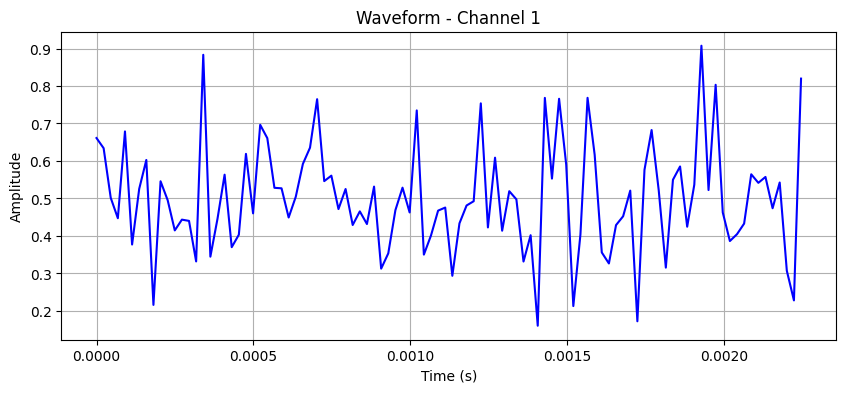

In [41]:
num_samples = 100

# Separate the channels
channel_1 = X[100]

# Create the time axis for plotting (in seconds)
time_axis = torch.arange(0, num_samples) / sample_rate

# Plot Channel 1
plt.figure(figsize=(10, 4))
plt.plot(time_axis.numpy(), channel_1.cpu().numpy(), label="Channel 1", color='b')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform - Channel 1")
plt.grid(True)

plt.show()

In [42]:
# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), device=device) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out, device=device) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim, device=device)
    self.beta = torch.zeros(dim, device=device)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim, device=device)
    self.running_var = torch.ones(dim, device=device)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [43]:
torch.manual_seed(42);

In [87]:
# Create an instance of the model
n_embd = input_size # the dimensionality of the character embedding vectors
n_hidden = 4
model = Sequential([
  # Embedding(X.shape[1], n_embd),
  Linear(n_embd, n_hidden, bias=False), BatchNorm1d(n_hidden), nn.ReLU(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), nn.ReLU(),
  # FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, Y.shape[1]),
])
# Print the model architecture
print(model)

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

442


In [107]:
max_steps = 20000
batch_size = batch_size
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 #if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/  20000: 0.6896
  10000/  20000: 0.4186


In [108]:
for layer in model.layers:
    layer.training = False

In [109]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 0.4738635718822479
val 0.5924810767173767


In [110]:
def check_success_rate(x, y):
    s = 0
    f = 0
    for i in range(x.shape[0]):
        predict = torch.argmax(model(x[i]))
        actual = torch.argmax(y[i])
        if predict.item() == actual.item():
            s += 1
        else:
            f += 1
    return s/(s+f)

In [114]:
print("Test set accuracy:{:.2f}".format(check_success_rate(Xte, Yte)))
print("Validation set accuracy:{:.2f}".format(check_success_rate(Xdev, Ydev)))
print("Train set accuracy:{:.2f}".format(check_success_rate(Xtr, Ytr)))

Test set accuracy:0.60
Validation set accuracy:0.72
Train set accuracy:0.77


In [101]:
check_success_rate(Xdev, Ydev)

3
4
7
9
13
14
20
22
25
27
30
38
46
48
49
50
54
55
56
62
63
65
79
85
88
89
92
93
99
104
106
108
112
114
115
117
122
123
126
127
128
129
130
133
137
138
139
140
142
151
157
158
161
109 53


0.6728395061728395

In [102]:
check_success_rate(Xtr, Ytr)

1
2
4
5
8
10
13
14
16
19
20
21
24
25
29
32
34
37
38
39
40
50
51
60
61
64
69
70
73
76
77
82
83
84
85
88
89
90
93
96
100
101
102
103
107
108
113
114
117
123
129
131
135
137
139
146
147
148
151
152
154
157
158
159
161
163
164
166
167
170
171
174
177
178
179
181
185
186
187
188
194
200
202
203
205
208
216
225
227
228
229
232
235
241
245
249
250
252
260
262
263
267
268
271
283
284
285
289
291
292
294
295
297
298
301
302
306
309
310
313
317
322
323
330
331
335
336
337
340
341
346
353
354
356
357
358
361
368
371
375
378
380
381
383
386
387
388
389
390
391
393
395
399
402
407
409
418
422
429
432
435
437
443
447
449
451
452
454
457
460
461
462
466
467
468
472
473
482
484
487
488
490
493
494
496
498
499
503
506
510
511
514
515
516
517
519
520
527
529
531
534
540
541
545
547
549
551
556
557
558
559
560
575
576
577
579
583
587
594
596
597
603
604
606
608
609
613
618
621
623
624
625
628
629
635
640
641
643
647
650
651
657
663
665
666
670
673
676
677
682
683
688
699
701
703
704
705
706
707
710
713
7

0.6327160493827161

In [65]:
model(Xte[0])

tensor([[ 2.4348, -1.9880]], device='cuda:0', grad_fn=<AddBackward0>)

In [67]:
Yte[0]

tensor([0.4444, 0.2229, 0.4371, 0.6905, 0.2633, 0.5706, 0.4074, 0.5665, 0.4579,
        0.8216, 0.2344, 0.5647, 0.7493, 0.3219, 0.6740, 0.2687, 0.5068, 0.4277,
        0.4161, 0.8039, 0.2151, 0.6452, 0.3584, 0.3566, 0.5357, 0.4774, 0.3057,
        0.4036, 0.6197, 0.3618, 0.4643, 0.4748, 0.4018, 0.3344, 0.4203, 0.5064,
        0.3218, 0.6734, 0.5255, 0.6167, 0.4336, 0.3846, 0.6171, 0.3501, 0.9794,
        0.5263, 0.7117, 0.6370, 0.5035, 0.6021, 0.4425, 0.5381, 0.4013, 0.7352,
        0.3252, 0.3356, 0.4932, 0.4518, 0.7298, 0.4947, 0.4107, 0.6712, 0.5656,
        0.8489, 0.5024, 0.5744, 0.4326, 0.4699, 0.6374, 0.5924, 0.7137, 0.1929,
        0.6993, 0.4634, 0.5830, 0.7409, 0.4228, 0.5917, 0.5538, 0.5182, 0.4322,
        0.4870, 0.5816, 0.6633, 0.6372, 0.4417, 0.1931, 0.5103, 0.8260, 0.4936,
        0.6856, 0.5103, 0.4983, 0.6505, 0.3702, 0.7185, 0.2876, 0.6573, 0.3928,
        0.5222], device='cuda:0')

In [207]:
a = torch.argmax(Yte[0])

In [208]:
a.item()

0

In [209]:
Xtr[104]

tensor([ 9.4727e-02,  3.6530e-02,  1.2695e-01, -1.4178e-01,  3.7903e-02,
         9.8724e-02, -1.6479e-02,  8.1024e-02,  1.1444e-02, -2.6184e-02,
         6.8390e-02,  1.2677e-01, -3.1708e-02,  2.1423e-02, -1.6006e-01,
        -2.0874e-02,  4.1870e-02, -1.1392e-01, -1.4423e-01, -1.0892e-01,
        -6.4301e-02, -2.0325e-02, -2.1628e-01,  3.1772e-01, -1.3123e-03,
         1.1786e-01,  3.0212e-02,  1.0275e-01, -1.6113e-02, -8.0109e-02,
        -6.9641e-02, -1.1429e-01,  8.3954e-02, -1.5683e-01,  8.4259e-02,
         3.5553e-02,  3.9276e-02,  6.3477e-03,  8.1177e-03,  1.2756e-02,
        -7.5867e-02,  1.3336e-02, -3.3142e-02,  5.7373e-03,  3.7720e-02,
         7.0801e-02,  4.8615e-02, -1.1591e-01, -3.1189e-02, -2.6947e-02,
        -3.5309e-02,  1.3440e-01, -6.7444e-03,  6.8390e-02,  7.0190e-02,
        -2.7313e-02,  2.0813e-02,  5.3711e-03, -4.3762e-02, -1.8860e-02,
         6.9122e-02,  9.1156e-02,  1.1169e-02, -6.0669e-02,  1.5472e-02,
         8.3588e-02,  1.1322e-02,  3.9032e-02, -1.0

In [141]:
Ytr[104]

tensor([0., 1.], device='cuda:0')